In [26]:
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from helpers.twitter_data_loader import TwitterDataset,padding_collate_fn,idx2cat
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay 

In [12]:
"""
Optionally run on CUDA as discussed in https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
pretrained = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(pretrained)
tokenizer.do_basic_tokenize = False

In [3]:
test_dataset = TwitterDataset("data/test_merged.csv", tokenizer)

396153it [02:23, 2753.02it/s]
c:\Users\joshu\OneDrive\Coding\HMC\lt_project\git\LTP_Final\helpers\twitter_data_loader.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.data = np.array(data)


In [13]:
test_dat = DataLoader(test_dataset,
		collate_fn=padding_collate_fn,
		batch_size = 32,
        shuffle=False)

In [21]:
model = BertForSequenceClassification.from_pretrained(pretrained,
			num_labels = 5,
			num_hidden_layers=1,
			num_attention_heads=12,
			output_attentions=True)
model.load_state_dict(torch.load("FINEmbert.pt"))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['bert.encoder.layer.8.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.7.output.dense.bias', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.9.intermediate.dense.weight', 'bert.encoder.layer.4.output.dense.weight', 'bert.encoder.layer.6.attention.output.LayerNorm.bias', 'bert.encoder.layer.5.intermediate.dense.weight', 'bert.encoder.layer.10.attention.output.LayerNorm.weight', 'bert.encoder.layer.8.output.dense.weight', 'bert.encoder.layer.5.output.dense.bias', 'bert.encoder.layer.4.attention.self.query.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.4.attention.output.LayerNorm.bias', 'bert.encoder.layer.11.output.dense.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.l

<All keys matched successfully>

In [22]:
model.to(device)
model.eval()
total_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_dat:
        data, labels = batch

        # mask
        """
        Masking for the attenntion mechanisms as also done in the
        transformers example.

        Source: https://huggingface.co/transformers/custom_datasets.html#fine-tuning-with-native-pytorch-tensorflow
        and: https://huggingface.co/transformers/model_doc/bert.html#transformers.BertForSequenceClassification
        """
        mask = torch.zeros_like(data)
        mask[data != 0] = 1
        mask = mask.float()
        mask = mask.to(device)

        data = data.to(device)

        y_pred = model(data,attention_mask=mask).logits
        y_pred = torch.argmax(y_pred, dim=1)
        

        if not device == "cpu":
            y_pred = y_pred.cpu()
        for p in y_pred:
            total_pred.append(p.item())

        correct += torch.sum(y_pred == labels).detach().numpy()
        total += len(labels)
print(correct/total)

0.8732935842807811


{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}


<Figure size 1200x800 with 0 Axes>

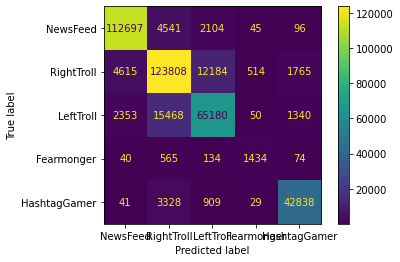

In [29]:
print(set(total_pred))
print(set(test_dataset.labels))
cnf = confusion_matrix(test_dataset.labels,np.array(total_pred))
disp = ConfusionMatrixDisplay(cnf,display_labels=idx2cat)
disp.plot(xticks_rotation="vertical")